# Introduction

In this notebook, we **fine-tune and test** **pre-trained large language models on the ADEPT dataset**.

ADEPT dataset: https://aclanthology.org/2021.acl-long.553/

Models:
* BERT: https://huggingface.co/docs/transformers/model_doc/bert
* DeBERTa: https://huggingface.co/docs/transformers/model_doc/deberta
* RoBERTa: https://huggingface.co/docs/transformers/model_doc/roberta
* MPNet: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

To keep it brief, we are going to demonstrate the fine-tuning and testing process on **RoBERTa** only as it showed the best performance out of the models we tried. However, the code can also easily be run on the other models. It will be shown below how to do that.

# Setup

The prerequisites to running the code are as follows:

1. Having all dependencies installed. This should have been achieved once you ran `pip install -r requirements.txt` and it finished successfully

2. Having the `datasets` folder with its contents stored in the same directory as this notebook. This should have been achieved when you cloned the repository to your local system

Import dependencies

In [63]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Tuple
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import f1_score

Choose model name

In [2]:
# switch model here: BERT, DeBERTa, RoBERTa, MPNet
model_name = "DeBERTa"

run_ID = 4  # to identify the results later

Time formatting function

In [3]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Set random seed values for reproducibility

In [4]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Introduce GPU

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Read the data

In [8]:
train = pd.read_json('../datasets/adept/train-dev-test-split/train.json')
dev = pd.read_json('../datasets/adept/train-dev-test-split/val.json')
test = pd.read_json('../datasets/adept/train-dev-test-split/test.json')

train['set'] = 'train'
dev['set'] = 'dev'
test['set'] = 'test'
df = pd.concat([train, dev, test])

In [9]:
df.head()

,sentence1,sentence2,modifier,noun,label,idx,set
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484,train
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620,train
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324,train
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610,train
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917,train


In [10]:
df['set'].value_counts()

train    12892
test      1612
dev       1611
Name: set, dtype: int64

Only keep label classes 1, 2 and 3 (comparison labels). Map them to 0, 1 and 2 for training convenience:

* 1 => 0
* 2 => 1
* 3 => 2

In [11]:
df = df[df['label'].isin([1, 2, 3])]
df['label'].value_counts()

2    10805
1     1868
3     1132
Name: label, dtype: int64

In [12]:
df['label'] -= 1
df['label'].value_counts()

1    10805
0     1868
2     1132
Name: label, dtype: int64

Filter out duplicated data points

In [13]:
df = df.drop_duplicates(subset=['sentence2'], keep='first')
df['label'].value_counts()

1    10800
0     1866
2     1129
Name: label, dtype: int64

In [14]:
train = df[df['set'] == 'train']
dev = df[df['set'] == 'dev']
test = df[df['set'] == 'test']

# Class balance

In [15]:
train['label'].value_counts()

1    8631
0    1503
2     926
Name: label, dtype: int64

The training data is heavily skewed towards class 1. As an option, we can balance the training data by randomly sampling 1500 examples from this class instead of using all of its samples

In [16]:
balance = False  # set to True to balance training data

if balance:
  train = pd.concat([
      train[train['label'].isin([0, 2])],
      train[train['label'] == 1].sample(1500, random_state=seed_val)
  ])
train['label'].value_counts()

1    8631
0    1503
2     926
Name: label, dtype: int64

In [17]:
train.shape

(11060, 7)

Save the data frame to make the results reproducible

In [18]:
train.to_csv('../datasets/adept/train_comparison_balanced.csv', index=False)

In [19]:
train = pd.read_csv(f'../datasets/adept/train_comparison_balanced.csv')
train.head()

,sentence1,sentence2,modifier,noun,label,idx,set
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,2,13484,train
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,1,2620,train
2,A scene is painted.,A negative scene is painted.,negative,scene,1,3324,train
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,1,10610,train
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,1,14917,train


In [20]:
df = pd.concat([train, dev, test])
df.reset_index(inplace=True, drop=True)
df.shape

(13795, 7)

# Tokenization

Our text input for the model will be sentence1 and sentence2 concatenated. Let's generate that input

In [21]:
df['sent_concat'] = df.apply(lambda row: row['sentence1'] + ' ' + row['sentence2'], axis=1)

Now we need to load the tokenizer to prepare the model input

In [22]:
match model_name:
    case "BERT":
        from transformers import BertTokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    case "DeBERTa":
        from transformers import DebertaTokenizer
        tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    case "RoBERTa":
        from transformers import RobertaTokenizer
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    case "MPNet":
        from transformers import MPNetTokenizer
        tokenizer = MPNetTokenizer.from_pretrained("microsoft/mpnet-base")
    case _:
        from transformers import BertTokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

Now let's calculate max input document length in tokens

In [25]:
max_len = 0
for doc in df['sent_concat']:
    input_ids = tokenizer.encode(doc, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
max_len

44

Our input to the BERT model will be formatted as follows:
> `[CLS] sentence1 [SEP] sentence2 [SEP] `

Seeing that the maximum document length is 46 tokens, we will set the max length hyperparameter to 64



Tokenization function

In [23]:
def tokenize(input_text: list[str]) -> Tuple[torch.Tensor, torch.Tensor]:
  input_ids = []
  attention_masks = []

  for doc in tqdm(input_text):
      encoded_dict = tokenizer.encode_plus(
                          doc,                       # Document to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attention masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

Apply the tokenization function to the data

In [24]:
# train
train_docs = df[df['set'] == 'train']['sent_concat'].to_list()
train_input_ids, train_attention_masks = tokenize(train_docs)

# validation (dev)
dev_docs = df[df['set'] == 'dev']['sent_concat'].to_list()
dev_input_ids, dev_attention_masks = tokenize(dev_docs)

# test
test_docs = df[df['set'] == 'test']['sent_concat'].to_list()
test_input_ids, test_attention_masks = tokenize(test_docs)

100%|██████████| 1380/1380 [00:00<00:00, 4209.12it/s]


Create `torch` datasets and dataloaders to conveniently load the data into the model

In [25]:
# train
train_labels = torch.tensor(df[df['set'] == 'train']['label'].to_list())
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# validation (dev)
dev_labels = torch.tensor(df[df['set'] == 'dev']['label'].to_list())
validation_dataset = TensorDataset(dev_input_ids, dev_attention_masks, dev_labels)

# test
test_labels = torch.tensor(df[df['set'] == 'test']['label'].to_list())
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [26]:
batch_size = 16

# train
train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),  # Select batches randomly
            batch_size=batch_size
        )

# validation (dev)
validation_dataloader = DataLoader(
            validation_dataset,
            sampler=SequentialSampler(validation_dataset),  # Pull out batches sequentially
            batch_size=batch_size
        )

# test
test_dataloader = DataLoader(
            test_dataset,
            sampler=SequentialSampler(test_dataset),  # Pull out batches sequentially
            batch_size=batch_size
        )

print(f'train:  {len(train_dataset)} data points, {len(train_dataloader)} batches')
print(f'validation (dev): {len(validation_dataset)} data points, {len(validation_dataloader)} batches')
print(f'test: {len(test_dataset)} data points, {len(test_dataloader)} batches')

train:  11060 data points, 692 batches
validation (dev): 1355 data points, 85 batches
test: 1380 data points, 87 batches


# Model

With the data at the ready, we load the pre-trained model of choice

In [27]:
match model_name:
    case "BERT":
        from transformers import BertForSequenceClassification
    case "DeBERTa":
        from transformers import DebertaForSequenceClassification
    case "RoBERTa":
        from transformers import RobertaForSequenceClassification
    case "MPNet":
        from transformers import MPNetForSequenceClassification
    case _:
        from transformers import BertForSequenceClassification

from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [28]:
match model_name:
    case "BERT":
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case "DeBERTa":
        model = DebertaForSequenceClassification.from_pretrained(
            "microsoft/deberta-base",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case "RoBERTa":
        model = RobertaForSequenceClassification.from_pretrained(
            "roberta-base",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case "MPNet":
        model = MPNetForSequenceClassification.from_pretrained(
            "microsoft/mpnet-base",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
    case _:
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels = 3,
            output_attentions = False,
            output_hidden_states = False,
        )
model.to(device);

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialize `AdamW` optimizer and learning rate scheduler. We are going to train for 3 epochs

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8  # default
                )

In [30]:
epochs = 3

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

We will use macro F1 to evaluate intermediate results

In [31]:
def flat_f1_score(y_true, y_pred, average='macro'):
  y_pred = np.argmax(y_pred, axis=1).flatten()
  return f1_score(y_true, y_pred, average=average)

# Training

And now we are ready to train. We are going to run validation on the dev set after every epoch and gather the statistics.

## Training loop

In [32]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    # training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # if step % 40 == 0 and not step == 0:  # progress update
        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss, logits = output.loss, output.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        del batch
        # break  # 1 batch run for sanity checks

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # validation
    print("")
    print("Validation...")

    t0 = time.time()
    model.eval()
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss, logits = output.loss, output.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1).flatten()
        b_labels = b_labels.to('cpu').numpy()

        total_eval_f1 += f1_score(b_labels, predictions, average='macro')
        del batch
        # break  # 1 batch run for sanity checks

    # Report the final accuracy for this validation run.
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print("  Macro F1: {0:.2f}".format(avg_val_f1))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Macro F1.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.61
  Training epoch took: 0:02:59

Validation...
  Macro F1: 0.45
  Validation Loss: 0.54
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.50
  Training epoch took: 0:02:49

Validation...
  Macro F1: 0.53
  Validation Loss: 0.54
  Validation took: 0:00:06

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.40
  Training epoch took: 0:02:47

Validation...
  Macro F1: 0.54
  Validation Loss: 0.58
  Validation took: 0:00:06

Training complete!
Total training took 0:08:52 (h:mm:ss)


## Training stats

Let's see how the training panned out. The plot shows the average training and validation losses of a given epoch against the epoch number. In this case, we can see that the model went into overfitting after epoch 2.

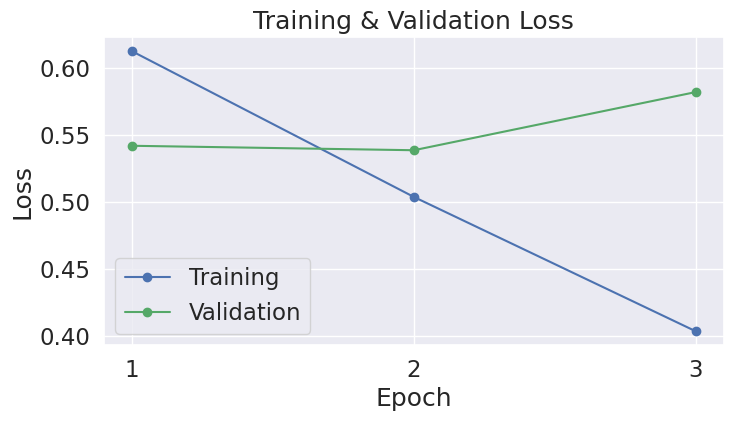

In [38]:
training_stats = pd.DataFrame(data=training_stats)

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,4)

plt.plot(training_stats['epoch'], training_stats['Training Loss'], 'b-o', label="Training");
plt.plot(training_stats['epoch'], training_stats['Valid. Loss'], 'g-o', label="Validation");

plt.title("Training & Validation Loss");
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.legend();
plt.xticks(range(1, epochs + 1));

plt.show()

## Save the model

In [65]:
os.makedirs('models', exist_ok=True)
filename = "models/" + model_name + "_" + str(run_ID) + "_" + "ep" + str(epochs) + "_"
if balance:
    filename += "balanced"
else:
    filename += "full"
filename += ".pt"
print(filename)
torch.save(model, filename)

models/DeBERTa_4_ep3_full.pt


# Validation

Run validation to compare performance to the one reported in the Adept paper

In [43]:
dev_set_predictions = []

for batch in tqdm(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss, logits = output.loss, output.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1).flatten()
        dev_set_predictions.append(predictions)

        del batch

100%|██████████| 85/85 [00:05<00:00, 14.84it/s]


In [44]:
dev_set_predictions = np.concatenate(dev_set_predictions, axis=0)

# Testing

Run the model on the test set for an final independent evaluation

In [39]:
test_set_predictions = []

for batch in tqdm(test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels)
        loss, logits = output.loss, output.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1).flatten()
        test_set_predictions.append(predictions)

        del batch

100%|██████████| 87/87 [00:06<00:00, 12.65it/s]


In [40]:
test_set_predictions = np.concatenate(test_set_predictions, axis=0)

# Plots & Statistics

The authors of the original ADEPT paper plot the confusion matrix to illustrate the performance on the development (validation) set (see p. 7124, fig. 2 & 3). To compare our results to theirs, we will plot a confusion matrix as well

In [41]:
from sklearn.metrics import confusion_matrix

In [45]:
# normalize='all' -- same as in Adept paper
# normalize='true' -- normalize along rows
norm_setting = 'true'

dev_conf_matr = confusion_matrix(df[df['set'] == 'dev']['label'].to_list(), dev_set_predictions,
                                 normalize=norm_setting)
dev_conf_matr = pd.DataFrame(dev_conf_matr, columns=['Less likely', 'Equally likely', 'More likely'],
                             index=['Less likely', 'Equally likely', 'More likely'])

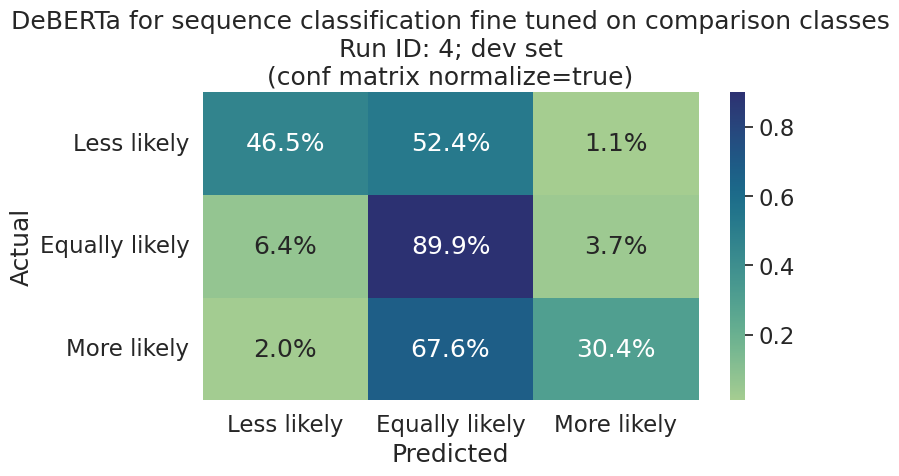

In [59]:
sns.heatmap(dev_conf_matr, cmap='crest', annot=True, fmt=".1%");
plt.title(f"""{model_name} for sequence classification fine tuned on comparison classes
Run ID: {run_ID}; dev set
(conf matrix normalize={norm_setting})""");
plt.ylabel('Actual');
plt.xlabel('Predicted');

To otherwise evaluate the performance, we use macro F1 score, weighted F1 score and one-vs-all class-wise F1 scores

In [51]:
dev_labels = df[df['set'] == 'dev']['label'].to_list()
test_labels = df[df['set'] == 'test']['label'].to_list()

In [52]:
macro_f1_dev = f1_score(dev_labels, dev_set_predictions, average='macro')
macro_f1_test = f1_score(test_labels, test_set_predictions, average='macro')
print(f'Dev set: macro F1 = {macro_f1_dev:.2f}')
print(f'Test set: macro F1 = {macro_f1_test:.2f}')

Dev set: macro F1 = 0.58
Test set: macro F1 = 0.54


Weighted F1

In [53]:
weighted_f1_dev = f1_score(dev_labels, dev_set_predictions, average='weighted')
weighted_f1_test = f1_score(test_labels, test_set_predictions, average='weighted')
print(f'Dev set: weighted F1 = {weighted_f1_dev:.2f}')
print(f'Test set: weighted F1 = {weighted_f1_test:.2f}')

Dev set: weighted F1 = 0.79
Test set: weighted F1 = 0.77


F1 "one vs all" for each class

In [55]:
def f1_one_vs_all(true, pred, class_label):
  true = [0 if v != class_label else 1 for v in true]
  pred = [0 if v != class_label else 1 for v in pred]
  return f1_score(true, pred)

In [58]:
f1_less, f1_eq, f1_more = f1_one_vs_all(dev_labels, dev_set_predictions, class_label=0), \
                          f1_one_vs_all(dev_labels, dev_set_predictions, class_label=1), \
                          f1_one_vs_all(dev_labels, dev_set_predictions, class_label=2)
f1_less, f1_eq, f1_more
print(f"""Dev set: one-vs-all F1
1 - Less likely: {f1_less:.2f}
2 - Equally likely: {f1_eq:.2f}
3 - More likely: {f1_more:.2f}
""")

f1_less, f1_eq, f1_more = f1_one_vs_all(test_labels, test_set_predictions, class_label=0), \
                          f1_one_vs_all(test_labels, test_set_predictions, class_label=1), \
                          f1_one_vs_all(test_labels, test_set_predictions, class_label=2)
f1_less, f1_eq, f1_more
print(f"""Test set: one-vs-all F1
1 - Less likely: {f1_less:.2f}
2 - Equally likely: {f1_eq:.2f}
3 - More likely: {f1_more:.2f}""")

Dev set: one-vs-all F1
1 - Less likely: 0.50
2 - Equally likely: 0.88
3 - More likely: 0.35

Test set: one-vs-all F1
1 - Less likely: 0.42
2 - Equally likely: 0.87
3 - More likely: 0.32


We will report and compare results obtained from different models in the project documentaion